In [1]:
using OrdinaryDiffEq, ParameterizedFunctions
using Optim, LsqFit 
using Plots, StatsPlots, LaTeXStrings
using DelimitedFiles, DataFrames
using Statistics
using Printf

In [2]:
ENV["COLUMNS"]=120
figdir = "figures/";

In [3]:
include("VirusLoadCurve.jl")
using .VirusLoadCurve

# Viral load data fitting



## Data set



In [4]:
filename = "../../data/Baccam2008/table1.csv"
temp = readdlm(filename, ',', Float64, '\n', header=true)
DATA = DataFrame(temp[1], Symbol.(temp[2][:]))
insertcols!(DATA, 2, "0" => 0.5)

6×10 DataFrame
 Row │ Patient  0        1        2        3        4        5        6        7        8       
     │ Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64 
─────┼──────────────────────────────────────────────────────────────────────────────────────────
   1 │     1.0      0.5      2.0      5.5      4.0      5.5      3.0      0.5      0.5      0.5
   2 │     2.0      0.5      1.0      6.0      3.0      1.5      3.5      1.3      0.5      0.5
   3 │     3.0      0.5      2.5      5.0      5.0      3.0      5.5      3.5      0.5      0.5
   4 │     4.0      0.5      3.5      5.5      6.5      5.5      3.5      4.0      0.5      0.5
   5 │     5.0      0.5      2.5      3.0      6.5      6.5      2.0      0.8      0.5      0.5
   6 │     6.0      0.5      4.0      5.0      5.5      7.5      5.5      1.3      0.5      0.5

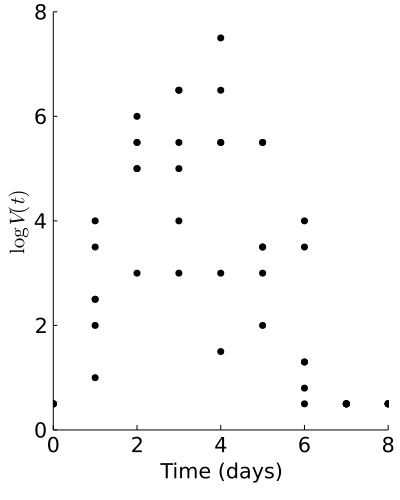

In [5]:
vlims = (0., 8)
plt = plot(legend=:none, ylims=vlims)
tdata = parse.(Float64, names(DATA)[2:end])
for k ∈ 1:size(DATA, 1)
    vdata = Array(DATA[k, 2:end])
    data = VirusLoadCurve.VirusLoadData(tdata, vdata)
    plot!(plt, data, size = (400, 500), color=:black)
end
display(plt)

## Fitting the standard virus load function to each individual in all groups (nasal swab)

Consider a virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.

In [6]:
results = []
tdata = parse.(Float64, names(DATA)[2:end])
for k ∈ 1:size(DATA, 1)
    vdata = Array(DATA[k, 2:end])
    data = VirusLoadCurve.VirusLoadData(tdata, vdata)
    resultVLF = VirusLoadCurve.fitVLF(data)
    push!(results, resultVLF)
end

Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:52
Finding possible parameter values 100%|█████████████████| Time: 0:00:08


Number of possible parameters found: 10533 (out of 1000000 testted)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:31
Finding possible parameter values 100%|█████████████████| Time: 0:00:08


Number of possible parameters found: 104443 (out of 1000000 testted)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:01:00
Finding possible parameter values 100%|█████████████████| Time: 0:00:08


Number of possible parameters found: 26197 (out of 1000000 testted)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:31
Finding possible parameter values 100%|█████████████████| Time: 0:00:08


Number of possible parameters found: 3992 (out of 1000000 testted)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:31
Finding possible parameter values 100%|█████████████████| Time: 0:00:08


Number of possible parameters found: 4157 (out of 1000000 testted)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:24
Finding possible parameter values 100%|█████████████████| Time: 0:00:08


Number of possible parameters found: 14244 (out of 1000000 testted)


In [12]:
using JLD2, FileIO
# save("Baccam2008Results.jld2", Dict("results" => results))
results = load("Baccam2008Results.jld2", "results");

In [13]:
io = IOBuffer(append=true)
function param_extrema(result)
    param_array = result.param_array
    param = result.fit.param
    if length(param_array)==0 return (param, param) end
    array = map(x -> map(y -> y[x], param_array), 1:length(param_array[1]))
    param_lower = map(minimum, array)
    param_upper = map(maximum, array)
    return (param_lower, param_upper)
end
print(io, @sprintf "\nData & \$\\log V_{\\max}\$ & \$a_1\$ & \$a_2\$ & \$\\alpha\$ & \$b_1\$ & \$b_2\$ & RSS & \\lambda \\\\ \n")
function VLFResultsLatex(dataname, result)
    print(io, @sprintf "%s & " dataname)
#     print(io, @sprintf "%.2f \$\\cdot 10^{%d}\$ & " 10^rem(result.fit.param[6], 1) floor(result.fit.param[6]))
    print(io, @sprintf "%.2f & " result.fit.param[6])
    print(io, @sprintf "%.2f & " result.fit.param[1])
    print(io, @sprintf "%.2f & " result.fit.param[2])
    print(io, @sprintf "%.2f & " result.fit.param[5])
    print(io, @sprintf "%.2f & " result.fit.param[3])
    print(io, @sprintf "%.2f & " result.fit.param[4])
    print(io, @sprintf "%.3f & " sum(abs2, result.fit.resid))
    print(io, @sprintf "%.2f \\\\ \n" 5.2/(result.fit.param[2] - result.fit.param[1]))
    lower, upper = param_extrema(result)
    print(io, @sprintf "  & ")
#     print(io, @sprintf "(%.2f \$\\cdot 10^{%d}\$, %.2f \$\\cdot 10^{%d}\$) & " 10^rem(lower[6], 1) floor(lower[6]) 10^rem(upper[6], 1) floor(upper[6]))
    print(io, @sprintf "(%.2f, %.2f) & " lower[6] upper[6])
    print(io, @sprintf "(%.2f, %.2f) & " lower[1] upper[1])
    print(io, @sprintf "(%.2f, %.2f) & " lower[2] upper[2])
    print(io, @sprintf "(%.2f, %.2f) & " lower[5] upper[5])
    print(io, @sprintf "(%.2f, %.2f) & " lower[3] upper[3])
    print(io, @sprintf "(%.2f, %.2f) & " lower[4] upper[4])
    print(io, @sprintf "\$\\leq\$ %.3f & -- \\\\ \n" (1.0 - 2/(length(result.data.t)-4)*log(0.15))*sum(abs2, result.fit.resid))
end

VLFResultsLatex (generic function with 1 method)

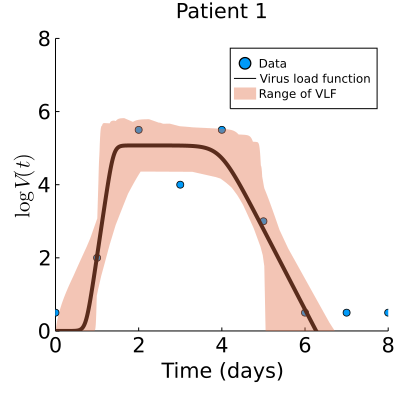

Patient 1: 
RSS = 1.98594e+00
a₁ = 1.0544804615402372, CI=(0.6826061382348197, 1.3913703472063246)
a₂ = 1.730736037536885, CI=(1.0084192748199685, 3.526863794851105)
b₁ = 2.7738365835013497, CI=(2.1272135696833185, 5.178939483949163)
b₂ = 5.143758272260935, CI=(4.840208624734434, 6.231857455146723)
α = 9.999999994736442e-9, CI=(9.999999994736442e-9, 1.5664174927976138)
logVmax = 5.073094685321973, CI=(4.359277681278724, 5.982488137145747)


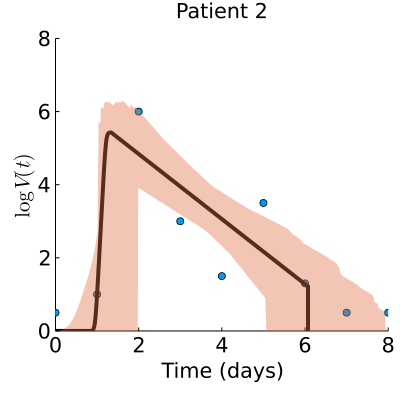




Patient 2: 
RSS = 6.45100e+00
a₁ = 1.0891296377727546, CI=(0.8098049383232595, 1.9969447581701358)
a₂ = 1.3375904030015127, CI=(1.0039679270513273, 2.736914370607064)
b₁ = 6.072208213751138, CI=(2.1677047708611816, 7.999929842954449)
b₂ = 6.072208213751138, CI=(5.01965379073898, 7.999999691757489)
α = 2.0493007328157153, CI=(0.6901081526255615, 3.5290481600894026)
logVmax = 5.429544541396975, CI=(3.705625831483705, 6.832996443883316)


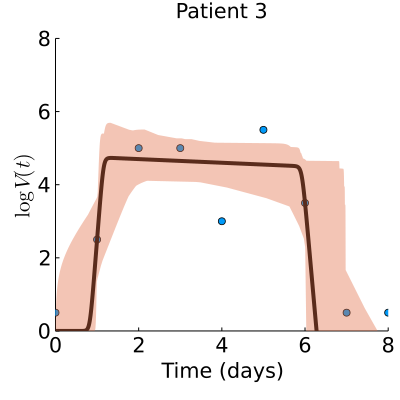




Patient 3: 
RSS = 3.67500e+00
a₁ = 0.9741834957540405, CI=(0.0007429580975372163, 1.282810627024488)
a₂ = 1.3342627005391623, CI=(1.0063551898108078, 4.911140013784401)
b₁ = 5.7198595910481504, CI=(3.4715906580217486, 6.98910249503988)
b₂ = 6.129959920207081, CI=(6.006465586423106, 7.461721367819564)
α = 0.11512925466994908, CI=(1.496768569490825e-5, 1.5295304076307408)
logVmax = 4.733286864988281, CI=(4.0671371761973925, 5.919940084673918)


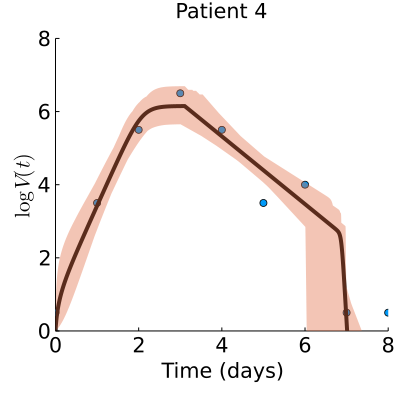




Patient 4: 
RSS = 1.30353e+00
a₁ = 1.047819887644125, CI=(0.5790986819763158, 1.3604810547310833)
a₂ = 3.1061899652334457, CI=(2.5952676254479066, 3.7349473694969717)
b₁ = 6.736732075181681, CI=(4.775744853651154, 6.992048416489509)
b₂ = 7.016828617073334, CI=(6.0284120425239545, 7.808561928573453)
α = 2.1343682194617806, CI=(1.358410862627505, 3.1128551814712053)
logVmax = 6.151081813883685, CI=(5.63413270569165, 6.6947250278435195)


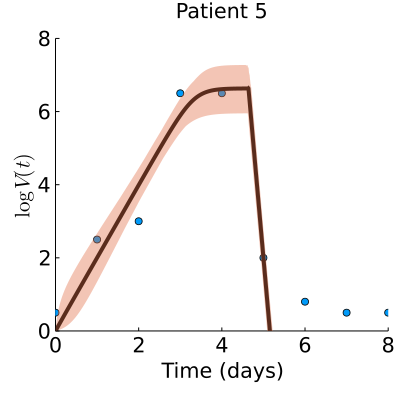




Patient 5: 
RSS = 1.69980e+00
a₁ = 2.0186543236952272, CI=(1.574777382903855, 2.3469606450590508)
a₂ = 4.640013017255443, CI=(4.545870705373784, 4.733589557194351)
b₁ = 7.336587783336898, CI=(4.631600371369383, 7.999723812835575)
b₂ = 7.336587783336898, CI=(5.2536064663564055, 7.999983775891582)
α = 29.631797290009228, CI=(27.952810251173496, 31.127813947366132)
logVmax = 6.632853085123956, CI=(5.952805655436097, 7.301502949354181)


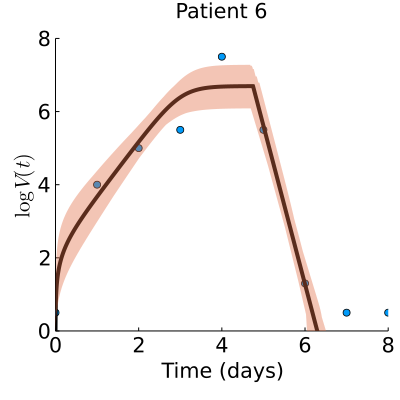




Patient 6: 
RSS = 1.60649e+00
a₁ = 1.2706579567002503, CI=(0.39291830088073054, 1.8281893099482893)
a₂ = 4.750198285060073, CI=(4.487723788139206, 4.970157776788031)
b₁ = 7.010021863766723, CI=(4.546943763826782, 7.999730854850903)
b₂ = 7.010021863766723, CI=(5.440453878586401, 7.9999967137345624)
α = 9.98340500936921, CI=(8.186079486509136, 11.895091472818901)
logVmax = 6.696302669586819, CI=(6.074735944550953, 7.32501261930929)




Data & $\log V_{\max}$ & $a_1$ & $a_2$ & $\alpha$ & $b_1$ & $b_2$ & RSS & \lambda \\ 
Patient 1 & 5.07 & 1.05 & 1.73 & 0.00 & 2.77 & 5.14 & 1.986 & 7.69 \\ 
  & (4.36, 5.98) & (0.68, 1.39) & (1.01, 3.53) & (0.00, 1.57) & (2.13, 5.18) & (4.84, 6.23) & $\leq$ 3.493 & -- \\ 
Patient 2 & 5.43 & 1.09 & 1.34 & 2.05 & 6.07 & 6.07 & 6.451 & 20.93 \\ 
  & (3.71, 6.83) & (0.81, 2.00) & (1.00, 2.74) & (0.69, 3.53) & (2.17, 8.00) & (5.02, 8.00) & $\leq$ 11.346 & -- \\ 
Patient 3 & 4.73 & 0.97 & 1.33 & 0.12 & 5.72 & 6.13 & 3.675 & 14.44 \\ 
  & (4.07, 5.92) & (0.00,

In [14]:
cases = "Patient ".*string.(Int.(DATA[:, 1]))
filename = "Baccam2006-"
for (resultVLF, case, k) ∈ zip(results, cases, 1:length(cases))
    println(case*": ")
    summary(resultVLF)
    VLFResultsLatex(case, resultVLF)
    pt = plot(resultVLF.data, size = (400, 400))
    if k > 1
        plot!(pt, legend=:none)
    end
    plot!(pt, resultVLF)
    ylims!(pt, vlims)
    title!(pt, case)
    savefig(figdir*filename*replace(case, " " => "-")*".png")
    savefig(figdir*filename*replace(case, " " => "-")*".pdf")
    display(pt)
    println("\n\n")
end
print(read(io, String))
print(read(io, String))

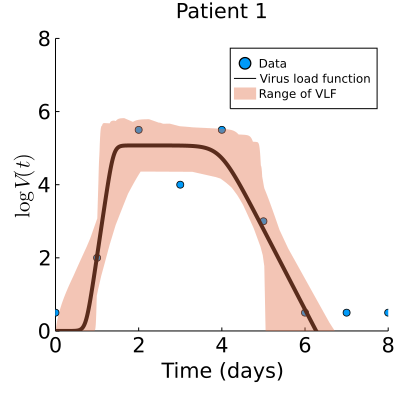

Patient 1: 
RSS = 1.98594e+00
a₁ = 1.0544804615402372, CI=(0.6826061382348197, 1.3913703472063246)
a₂ = 1.730736037536885, CI=(1.0084192748199685, 3.526863794851105)
b₁ = 2.7738365835013497, CI=(2.1272135696833185, 5.178939483949163)
b₂ = 5.143758272260935, CI=(4.840208624734434, 6.231857455146723)
α = 9.999999994736442e-9, CI=(9.999999994736442e-9, 1.5664174927976138)
logVmax = 5.073094685321973, CI=(4.359277681278724, 5.982488137145747)


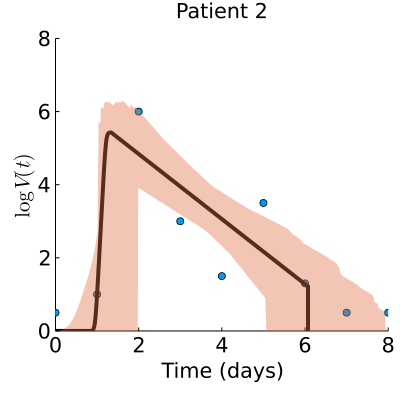




Patient 2: 
RSS = 6.45100e+00
a₁ = 1.0891296377727546, CI=(0.8098049383232595, 1.9969447581701358)
a₂ = 1.3375904030015127, CI=(1.0039679270513273, 2.736914370607064)
b₁ = 6.072208213751138, CI=(2.1677047708611816, 7.999929842954449)
b₂ = 6.072208213751138, CI=(5.01965379073898, 7.999999691757489)
α = 2.0493007328157153, CI=(0.6901081526255615, 3.5290481600894026)
logVmax = 5.429544541396975, CI=(3.705625831483705, 6.832996443883316)


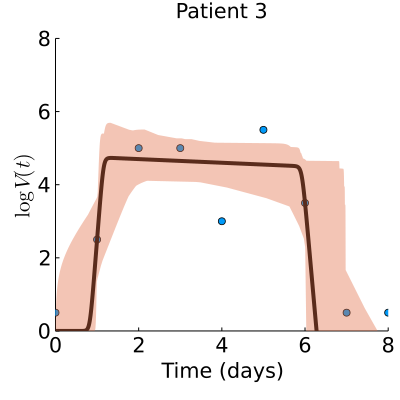




Patient 3: 
RSS = 3.67500e+00
a₁ = 0.9741834957540405, CI=(0.0007429580975372163, 1.282810627024488)
a₂ = 1.3342627005391623, CI=(1.0063551898108078, 4.911140013784401)
b₁ = 5.7198595910481504, CI=(3.4715906580217486, 6.98910249503988)
b₂ = 6.129959920207081, CI=(6.006465586423106, 7.461721367819564)
α = 0.11512925466994908, CI=(1.496768569490825e-5, 1.5295304076307408)
logVmax = 4.733286864988281, CI=(4.0671371761973925, 5.919940084673918)


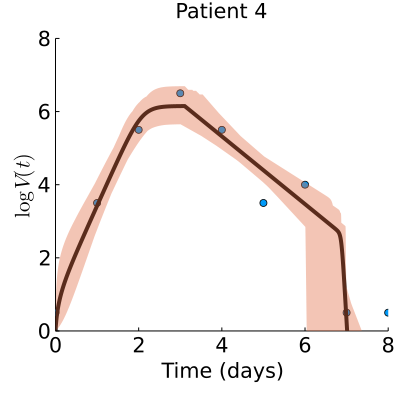




Patient 4: 
RSS = 1.30353e+00
a₁ = 1.047819887644125, CI=(0.5790986819763158, 1.3604810547310833)
a₂ = 3.1061899652334457, CI=(2.5952676254479066, 3.7349473694969717)
b₁ = 6.736732075181681, CI=(4.775744853651154, 6.992048416489509)
b₂ = 7.016828617073334, CI=(6.0284120425239545, 7.808561928573453)
α = 2.1343682194617806, CI=(1.358410862627505, 3.1128551814712053)
logVmax = 6.151081813883685, CI=(5.63413270569165, 6.6947250278435195)


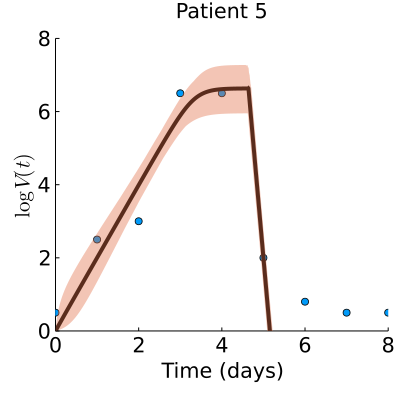




Patient 5: 
RSS = 1.69980e+00
a₁ = 2.0186543236952272, CI=(1.574777382903855, 2.3469606450590508)
a₂ = 4.640013017255443, CI=(4.545870705373784, 4.733589557194351)
b₁ = 7.336587783336898, CI=(4.631600371369383, 7.999723812835575)
b₂ = 7.336587783336898, CI=(5.2536064663564055, 7.999983775891582)
α = 29.631797290009228, CI=(27.952810251173496, 31.127813947366132)
logVmax = 6.632853085123956, CI=(5.952805655436097, 7.301502949354181)


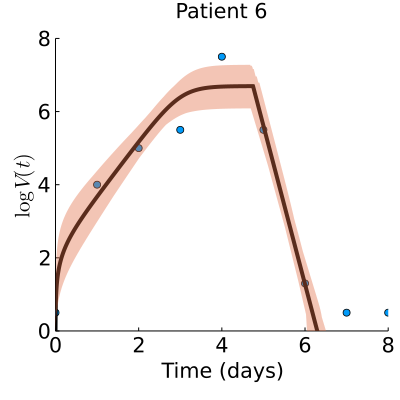




Patient 6: 
RSS = 1.60649e+00
a₁ = 1.2706579567002503, CI=(0.39291830088073054, 1.8281893099482893)
a₂ = 4.750198285060073, CI=(4.487723788139206, 4.970157776788031)
b₁ = 7.010021863766723, CI=(4.546943763826782, 7.999730854850903)
b₂ = 7.010021863766723, CI=(5.440453878586401, 7.9999967137345624)
α = 9.98340500936921, CI=(8.186079486509136, 11.895091472818901)
logVmax = 6.696302669586819, CI=(6.074735944550953, 7.32501261930929)



Patient 1 & 5.07 & 1.05 & 1.73 & 0.00 & 2.77 & 5.14 & 1.986 & 7.69 \\ 
  & (4.36, 5.98) & (0.68, 1.39) & (1.01, 3.53) & (0.00, 1.57) & (2.13, 5.18) & (4.84, 6.23) & $\leq$ 3.493 & -- \\ 
Patient 2 & 5.43 & 1.09 & 1.34 & 2.05 & 6.07 & 6.07 & 6.451 & 20.93 \\ 
  & (3.71, 6.83) & (0.81, 2.00) & (1.00, 2.74) & (0.69, 3.53) & (2.17, 8.00) & (5.02, 8.00) & $\leq$ 11.346 & -- \\ 
Patient 3 & 4.73 & 0.97 & 1.33 & 0.12 & 5.72 & 6.13 & 3.675 & 14.44 \\ 
  & (4.07, 5.92) & (0.00, 1.28) & (1.01, 4.91) & (0.00, 1.53) & (3.47, 6.99) & (6.01, 7.46) & $\leq$ 6.464 & -- 

In [15]:
cases = "Patient ".*string.(Int.(DATA[:, 1]))
filename = "Baccam2006-"
plots = []
for (resultVLF, case, k) ∈ zip(results, cases, 1:length(cases))
    println(case*": ")
    summary(resultVLF)
    VLFResultsLatex(case, resultVLF)
    pt = plot(resultVLF.data, size = (400, 400))
    if k > 1
        plot!(pt, legend=:none)
    end
    plot!(pt, resultVLF)
    ylims!(pt, vlims)
    title!(pt, case)
    savefig(figdir*filename*replace(case, " " => "-")*".png")
    savefig(figdir*filename*replace(case, " " => "-")*".pdf")
    display(pt)
    println("\n\n")
end
print(read(io, String))

In [10]:
function Boxplots(results)
    ndata = length(results)
    params = []
    for resultVLF ∈ results
        params = vcat(params, resultVLF.fit.param)
    end
    params = reshape(params, (6, ndata))
    param_names = results[1].names
    pt1 = plot(yaxis=("Time (days)", extrema(params[1:4, :]) .+ (-0.5, 0.5), font(14)), 
        xaxis=("Parameter", font(14)), 
        grid=false, legend=false, left_margin = 5Plots.mm, right_margin = 16Plots.mm)
    [boxplot!(pt1, repeat([param_names[i]], ndata), params[i, :], fillalpha=0.7, lw=2, color=1) for i = 1:4]
    [dotplot!(pt1, repeat([param_names[i]], ndata), params[i, :], marker=(:black, stroke(0))) for i = 1:4]
    pt2 = twinx()
    plot!(pt2, yaxis=("Decay rate (1/days)", extrema(params[5, :]) .+ (-0.2, 0.2), font(14)), 
        xaxis=("", font(14)), 
        grid=false, legend=false, left_margin = 5Plots.mm, right_margin = 16Plots.mm)
    boxplot!(pt2, repeat([param_names[5]], ndata), params[5, :], fillalpha=0.7, lw=2, color=2)
    dotplot!(pt2, repeat([param_names[5]], ndata), params[5, :], marker=(:black, stroke(0)))
    pt1
end

Boxplots (generic function with 1 method)

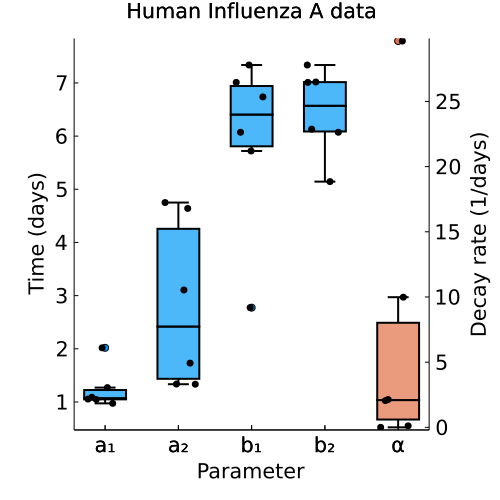

In [16]:
text_data = "Human Influenza A data"
text_file = "Baccam2006-Boxplot"
pt = Boxplots(results)
plot!(title = text_data, size=(500, 500))
savefig(figdir*text_file*".pdf")
savefig(figdir*text_file*".png")
display(pt)

In [17]:
for result ∈ results
    param = result.fit.param
    println(5.2/(param[2]-param[1])/log10(exp(1)))
end

17.705499087268734
48.190475757993745
33.25224651813542
5.816953235927256
4.567647500124154
3.4410989250448067
